In [1]:
# Import dependencies
import math 
import os
import numpy as np
import tensorflow as tf
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# define constants

# mnist has 10 classes
NUM_CLASSES = 10

# MNIST IMAGE SIZE IS ALWAYS 28 * 28
IMAGE_SIZE = 28
IMAGE_PIXEL = IMAGE_SIZE * IMAGE_SIZE

# BATCH SIZE, MUST BE DIVIDABLE BY DATASET SIZE
BATCH_SIZE = 100
EVAL_BATCH_SIZE = 1

# NUMBER OF UNITS IN HIDDEN LAYER
HIDDEN1_UNITS = 128
HIDDEN2_UNITS = 32

# MAXIMUM NUMBER OF TRAINING STEPS
MAX_STEPS = 2000

# DIRECTORY TO PUT THE TRAINING DATA
TRAIN_DIR = '/Users/ishansingh/Dropbox/To_GIT/TENSORFLOW/'

In [3]:
# get the set of images and labels for training, testing and validation data
data_set = read_data_sets(TRAIN_DIR, False)

Extracting /Users/ishansingh/Dropbox/To_GIT/TENSORFLOW/train-images-idx3-ubyte.gz
Extracting /Users/ishansingh/Dropbox/To_GIT/TENSORFLOW/train-labels-idx1-ubyte.gz
Extracting /Users/ishansingh/Dropbox/To_GIT/TENSORFLOW/t10k-images-idx3-ubyte.gz
Extracting /Users/ishansingh/Dropbox/To_GIT/TENSORFLOW/t10k-labels-idx1-ubyte.gz


### The network is created and connected here. IMP FACTS:

1. Has 2 hidden layers
2. Linear is the final layer or output layer

In [4]:
# Built inference graph!

# /*** Always an inference graph with produce logistic outputs

def mnist_inference(images, hidden1_units, hidden2_units):
    """Build the MNIST model up to where it may be used for inference.
    Args:
        images: Images placeholder.
        hidden1_units: Size of the first hidden layer.
    Returns:
        logits: Output tensor with the computed logits.
    """
    # hidden 1
    with tf.name_scope('hidden1'):
        weights = tf.Variable(
        tf.truncated_normal([IMAGE_PIXEL, hidden1_units],
                           stddev = 1.0 / math.sqrt(float(IMAGE_PIXEL))),
            name = 'weights'
        )
        biases = tf.Variable(tf.zeros([hidden1_units]),
                            name = 'biases')
        hidden1 = tf.nn.relu(tf.matmul(images, weights) + biases)
        
    
    # hidden 2
    with tf.name_scope('hidden2'):
        weights = tf.Variable(
        tf.truncated_normal([hidden1_units, hidden2_units],
                           stddev = 1.0 / math.sqrt(float(hidden1_units))),
            name = 'weights'
        )
        biases = tf.Variable(tf.zeros([hidden2_units]),
                            name = 'biases')
        hidden2 = tf.nn.relu(tf.matmul(hidden1, weights) + biases)
        
    # Linear
    with tf.name_scope('softmax_linear'):
        weights = tf.Variable(
        tf.truncated_normal([hidden2_units, NUM_CLASSES],
                           stddev = 1.0 / math.sqrt(float(hidden2_units))),
            name = 'weights'
        )
        biases = tf.Variable(tf.zeros([NUM_CLASSES]),
                            name = 'biases')
        logits = tf.nn.relu(tf.matmul(hidden2, weights) + biases)
    
    # The constructed graph
        tf.train.write_graph(tf.get_default_graph().as_graph_def(),
                            'TRAIN_DIR', "inference.pbtxt", as_text = True)
    
    return logits

In [5]:
# build training graph
def mnist_training(logits, labels, lr):
    """
    Build the training graph.
    Args-
        logits: logit tensor, float - [Batch_size: NUM_CLASS]
        labels: label tensor, int32 - [Batch_size], with values in the range [0:NUM_CLASS]
        lr = learning rate for gradient descent
        
    Returns-
        train_op: The op for training
        loss: The op for calculation loss
    """
    
    # create operation that calculates loss
    labels = tf.to_int64(labels)
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits = logits, labels = labels, name = 'xentropy')
    loss = tf.reduce_mean(cross_entropy, name = 'xentropy_mean')
    
    # create Optimizer with Learning Rate
    optimizer = tf.train.GradientDescentOptimizer(lr)
    
    # Create a variable to track the global step.
    global_step = tf.Variable(0, name = 'global_step', trainable= False)
    
    # use the optimizer to apply the gradient that minimizes loss (and also increement the
    # global step counter) as a single training step
    train_op = optimizer.minimize(loss, global_step = global_step)
    
    # The constructed graph
    tf.train.write_graph(tf.get_default_graph().as_graph_def(),
                         'TRAIN_DIR', "inference.pbtxt", as_text = True)

    return train_op, loss

In [6]:
# bulid the graph for feeding input, training and saving checkpoints

mnist_graph = tf.Graph()
with mnist_graph.as_default():
    # generate placeholder for image and labels
    image_placeholder = tf.placeholder(tf.float32)
    label_placeholder = tf.placeholder(tf.int32)
    tf.add_to_collection('images', image_placeholder) # Remember this OP
    tf.add_to_collection('labels', label_placeholder) # Remember this OP
    
    # build a graph that computes prediction from the inference model
    logits = mnist_inference(image_placeholder, HIDDEN1_UNITS, HIDDEN2_UNITS)
    tf.add_to_collection('logits', logits) # Remember this OP
    
    # add to the graph the Ops that calculates and apply Gradient
    train_op, loss = mnist_training(logits, label_placeholder, 0.01)
    
    # Add variable initializer Op.
    init = tf.global_variables_initializer()
    
    # Create checkpoints using Saver
    saver = tf.train.Saver()
    
    # The constructed graph
    tf.train.write_graph(tf.get_default_graph().as_graph_def(),
                         'TRAIN_DIR', "inference.pbtxt", as_text = True)

step 0: loss = 2.31
step 500: loss = 1.64
step 1000: loss = 1.04
step 1500: loss = 0.92


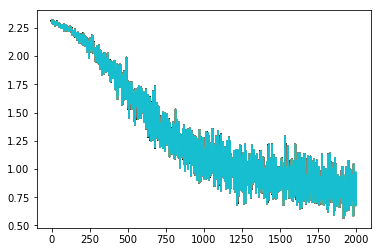

In [7]:
# run training for Max_steps and save checkpoints at the end
with tf.Session(graph = mnist_graph) as sess:
    sess.run(init)
    
    losses = []
    # start the training process 
    for step in range(MAX_STEPS):
        image_feed, label_feed = data_set.train.next_batch(BATCH_SIZE)
        
        _, loss_value = sess.run([train_op, loss],
                                feed_dict = {image_placeholder: image_feed,
                                             label_placeholder: label_feed})
        
        losses.append(loss_value)
        # print loss value:
        if step % 500 == 0:
            print('step %d: loss = %.2f' % (step, loss_value))
        plt.plot(losses)    
    checkpoint_file = os.path.join(TRAIN_DIR, 'checkpoint')
    saver.save(sess, checkpoint_file, global_step= step)

Actual Label: 2
 Prediction: 2


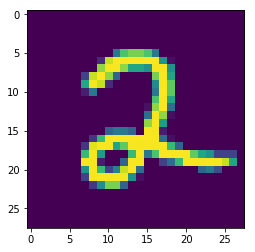

In [8]:
# Run Evaluations based on checkpoints
with tf.Session(graph= tf.Graph()) as sess:
    saver = tf.train.import_meta_graph(os.path.join(TRAIN_DIR, 'checkpoint-1999.meta'))
    saver.restore(
    sess, os.path.join(TRAIN_DIR, 'checkpoint-1999'))
    
    # retrieve ops we collected
    logits = tf.get_collection('logits')[0]
    image_placeholder = tf.get_collection('images')[0]
    label_placeholder = tf.get_collection('labels')[0]
    
    # add ops to choose for top k predictions
    eval_op = tf.nn.top_k(logits)
    
    # run evaluation
    image_feed, label_feed = data_set.train.next_batch(EVAL_BATCH_SIZE)
    imgplot = plt.imshow(np.reshape(image_feed, (28,28)))
    prediction = sess.run(eval_op,
                         feed_dict = {
                             image_placeholder: image_feed,
                             label_placeholder: label_feed
                         })
    
    print("Actual Label: %d\n Prediction: %d" % (label_feed, prediction.indices[0][0]))